In [1]:
!pip install scanpy loompy matplotlib mygene igraph scvi-tools scvi-colab celltypist

import scvi
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import celltypist
from celltypist import models
import mygene as mg
import pandas as pd
import loompy as lp
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.2/503.2 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5

/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


Mounted at /content/drive


### Predicting drug targets from scRNA-seq data

We will be using a scRNA-seq dataset (HDF5) from the NIH National Cancer Institute GDC [portal](https://portal.gdc.cancer.gov/analysis_page?app=Downloads). This data was generated by Illumina 10X Chromium sequencing and sampled from a White woman (Non-Hispanic/Latino) with Acute Myeloid Leukemia.

The workflow for this project is as follows:

Pre-process data:

- Ingest a single-cell RNA sequencing dataset
- Annotate appropriately
- Normalize & scale data (log-transform)
- Data exploration (highly variable genes, gene set enrichment analysis)
- Filter data (for highly variable genes to reduce dimensionality)
- Label data with druggable targets (present or not in Open Targets list: positive and negative class)

Train AI model:

- Instantiate, train and test supervised learning model to predict gene targets associated with drug efficacy
- Evaluate model performance
- Iterate on data and model optimization


By the end of this notebook we will have designed a reproducible end to end Bioinformatics pipeline incorporating single cell data pre-processing and analysis, model building, evaluation and optimization.

In [2]:
# Load the CSV file into a DataFrame
adata = sc.read_loom('/content/drive/MyDrive/genspace/1b9edaa1-5675-4d0e-8b97-0b1e757ccdef.seurat.1000x1000.loom')

In [3]:
adata

AnnData object with n_obs × n_vars = 4545 × 26324
    obs: 'SCT_snn_res.0.5', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'orig.ident', 'seurat_clusters'
    layers: 'counts'

In [4]:
adata.obs

,SCT_snn_res.0.5,nCount_RNA,nCount_SCT,nFeature_RNA,nFeature_SCT,orig.ident,seurat_clusters
CellID,,,,,,,
AAACCCAAGTGAGTTA-1,1,14981.0,11578.0,4202,4182,1,1
AAACCCACAAATACGA-1,2,9737.0,10126.0,3513,3513,1,2
AAACCCACACGGGTAA-1,1,8811.0,9842.0,2949,2949,1,1
AAACCCAGTAGTCCTA-1,3,13475.0,11372.0,4038,4029,1,3
AAACCCAGTCGATGCC-1,2,13323.0,11400.0,4038,4034,1,2
...,...,...,...,...,...,...,...
TTTGTTGAGCAACAGC-1,6,11908.0,11187.0,3845,3842,1,6
TTTGTTGAGTCTGCAT-1,3,10555.0,10557.0,3807,3807,1,3
TTTGTTGCAGACCTGC-1,2,16053.0,11194.0,4536,4479,1,2


In [5]:
adata.var

""
Gene
ENSG00000227232.5
ENSG00000238009.6
ENSG00000233750.3
ENSG00000268903.1
ENSG00000241860.7
...
ENSG00000198695.2
ENSG00000210194.1
ENSG00000198727.2


Our `var` data is improperly formatted with ".X" suffixes. These will pose a problem when annotating these gene IDs with their respective gene names. Let's remove those.

In [6]:
adata.var_names = adata.var_names.str.split('.').str[0]

In [7]:
adata.var

""
Gene
ENSG00000227232
ENSG00000238009
ENSG00000233750
ENSG00000268903
ENSG00000241860
...
ENSG00000198695
ENSG00000210194
ENSG00000198727


Now let's annotate the IDs with respective gene symbol information using the [MyGene Python API](https://docs.mygene.info/projects/mygene-py/en/latest/).

In [8]:
import mygene as mg

# Initialize MyGene.info
mg = mg.MyGeneInfo()

# Get Ensembl IDs from your AnnData object
ensembl_ids = adata.var_names.tolist()

# Query MyGene.info for gene names
query_result = mg.querymany(qterms=ensembl_ids, scopes="ensembl.gene", fields="symbol", species="human")

INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:querying 3001-4000 ...
INFO:biothings.client:querying 4001-5000 ...
INFO:biothings.client:querying 5001-6000 ...
INFO:biothings.client:querying 6001-7000 ...
INFO:biothings.client:querying 7001-8000 ...
INFO:biothings.client:querying 8001-9000 ...
INFO:biothings.client:querying 9001-10000 ...
INFO:biothings.client:querying 10001-11000 ...
INFO:biothings.client:querying 11001-12000 ...
INFO:biothings.client:querying 12001-13000 ...
INFO:biothings.client:querying 13001-14000 ...
INFO:biothings.client:querying 14001-15000 ...
INFO:biothings.client:querying 15001-16000 ...
INFO:biothings.client:querying 16001-17000 ...
INFO:biothings.client:querying 17001-18000 ...
INFO:biothings.client:querying 18001-19000 ...
INFO:biothings.client:querying 19001-20000 ...
INFO:biothings.client:querying 20001-21000 ...
INFO:biothings.client:querying 2100

In [9]:
print(query_result)

[{'query': 'ENSG00000227232', '_id': 'ENSG00000227232', '_score': 10.601599, 'symbol': 'WASH7P'}, {'query': 'ENSG00000238009', 'notfound': True}, {'query': 'ENSG00000233750', '_id': '100420257', '_score': 10.601599, 'symbol': 'CICP27'}, {'query': 'ENSG00000268903', '_id': 'ENSG00000268903', '_score': 32.864956}, {'query': 'ENSG00000241860', '_id': 'ENSG00000241860', '_score': 32.864956}, {'query': 'ENSG00000279457', '_id': 'ENSG00000279457', '_score': 10.601599, 'symbol': 'WASH9P'}, {'query': 'ENSG00000228463', '_id': '728481', '_score': 10.601599, 'symbol': 'RPL23AP21'}, {'query': 'ENSG00000237094', '_id': 'ENSG00000237094', '_score': 32.864956}, {'query': 'ENSG00000230021', '_id': 'ENSG00000230021', '_score': 32.864956}, {'query': 'ENSG00000225972', '_id': '100887749', '_score': 10.601599, 'symbol': 'MTND1P23'}, {'query': 'ENSG00000225630', '_id': '100652939', '_score': 10.601599, 'symbol': 'MTND2P28'}, {'query': 'ENSG00000237973', '_id': '107075141', '_score': 10.601599, 'symbol': '

In [10]:
# Convert to DataFrame
annotations = pd.DataFrame(query_result)[["query", "symbol"]].dropna()

# Map gene symbols back to AnnData var
adata.var["gene_name"] = adata.var_names.map(annotations.set_index("query")["symbol"].to_dict())

In [11]:
adata.var

,gene_name
Gene,
ENSG00000227232,WASH7P
ENSG00000238009,NaN
ENSG00000233750,CICP27
ENSG00000268903,NaN
ENSG00000241860,NaN
...,...
ENSG00000198695,ND6
ENSG00000210194,TRNE
ENSG00000198727,CYTB


Now we've annotated our gene IDs! But we're not done yet. We know there are empty rows present, and the index is still `Gene`. We need to check for duplicate rows and drop them. Check for NaNs and drop them. And make our index `gene_name` to make downstream visualization more interpretable.

In [12]:
print(adata.var["gene_name"].duplicated().sum())  # Number of duplicates

5304


We've got quite a few duplicate gene names here, so let's get rid of them. Importantly, we need to drop duplicates across the entire AnnData object and not just `adata.var`. This is because `scanpy` expects the number of rows in `adata.var` and `adata.X` to match, and if we only drop rows in `adata.var` that number will become less than the number of rows in `adata.X`.

In [13]:
# Identify unique gene names, keeping the first occurrence
unique_genes = ~adata.var.duplicated(subset="gene_name", keep="first")

# Subset AnnData based on unique genes
adata = adata[:, unique_genes].copy()

# Preserve original gene IDs before setting the index
adata.var["Gene"] = adata.var.index

# Set the index to gene_name
adata.var.set_index("gene_name", inplace=True)

In [14]:
adata.var

,Gene
gene_name,
WASH7P,ENSG00000227232
NaN,ENSG00000238009
CICP27,ENSG00000233750
WASH9P,ENSG00000279457
RPL23AP21,ENSG00000228463
...,...
ND6,ENSG00000198695
TRNE,ENSG00000210194
CYTB,ENSG00000198727


Now we can look for duplicates in `gene_name` and drop them.

In [15]:
print(adata.var.index.isna().sum())

1


In [16]:
# Drop NaN
adata = adata[:, ~adata.var.index.isna()].copy()

We don't have any cell-type level annotation in our data, which may make it hard for our model to make reliable predictions later on. We want to give our model as many supporting features as possible, to increase the likelihood of making strong predictions. Let's use the [CellTypist API](https://www.celltypist.org/models) to automatically assign cell types to `adata.obs`.

In [17]:
# Start by downloading all models (logistic regression)

models.download_models(force_update = True)

Let's take a look at the available models, and pick one that fits our use case.

In [18]:
models.models_description()

,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_COVID19_PBMC.pkl,peripheral blood mononuclear cell types from C...
3,Adult_CynomolgusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult cynom...
4,Adult_Human_MTG.pkl,cell types and subtypes (10x-based) from the a...
5,Adult_Human_PancreaticIslet.pkl,cell types from pancreatic islets of healthy a...
6,Adult_Human_PrefrontalCortex.pkl,cell types and subtypes from the adult human d...
7,Adult_Human_Skin.pkl,cell types from human healthy adult skin
8,Adult_Human_Vascular.pkl,vascular populations combined from multiple ad...
9,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...


In [19]:
# Indeed, the `model` argument defaults to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Immune_All_High.pkl')
model

CellTypist model with 32 cell types and 6639 features
    date: 2022-07-16 08:53:00.959521
    details: immune populations combined from 20 tissues of 18 studies
    source: https://doi.org/10.1126/science.abl5197
    version: v2
    cell types: B cells, B-cell lineage, ..., pDC precursor
    features: A1BG, A2M, ..., ZYX

In [20]:
model.cell_types

array(['B cells', 'B-cell lineage', 'Cycling cells', 'DC', 'DC precursor',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ETP',
       'Early MK', 'Endothelial cells', 'Epithelial cells',
       'Erythrocytes', 'Erythroid', 'Fibroblasts', 'Granulocytes',
       'HSC/MPP', 'ILC', 'ILC precursor', 'MNP', 'Macrophages',
       'Mast cells', 'Megakaryocyte precursor',
       'Megakaryocytes/platelets', 'Mono-mac', 'Monocyte precursor',
       'Monocytes', 'Myelocytes', 'Plasma cells', 'Promyelocytes',
       'T cells', 'pDC', 'pDC precursor'], dtype=object)

Now let's make predictions.

In [21]:
predictions = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = True)

In [22]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
CellID,,,
AAACCCAAGTGAGTTA-1,HSC/MPP,23,Double-negative thymocytes
AAACCCACAAATACGA-1,Double-negative thymocytes,45,Double-negative thymocytes
AAACCCACACGGGTAA-1,Megakaryocyte precursor,55,Double-negative thymocytes
AAACCCAGTAGTCCTA-1,Double-negative thymocytes,6,HSC/MPP
AAACCCAGTCGATGCC-1,HSC/MPP,54,HSC/MPP
...,...,...,...
TTTGTTGAGCAACAGC-1,HSC/MPP,24,HSC/MPP
TTTGTTGAGTCTGCAT-1,HSC/MPP,11,HSC/MPP
TTTGTTGCAGACCTGC-1,HSC/MPP,52,Double-negative thymocytes


In [23]:
adata = predictions.to_adata()

In [24]:
adata.obs

,SCT_snn_res.0.5,nCount_RNA,nCount_SCT,nFeature_RNA,nFeature_SCT,orig.ident,seurat_clusters,predicted_labels,over_clustering,majority_voting,conf_score
CellID,,,,,,,,,,,
AAACCCAAGTGAGTTA-1,1,14981.0,11578.0,4202,4182,1,1,HSC/MPP,23,Double-negative thymocytes,0.963224
AAACCCACAAATACGA-1,2,9737.0,10126.0,3513,3513,1,2,Double-negative thymocytes,45,Double-negative thymocytes,0.999929
AAACCCACACGGGTAA-1,1,8811.0,9842.0,2949,2949,1,1,Megakaryocyte precursor,55,Double-negative thymocytes,0.806382
AAACCCAGTAGTCCTA-1,3,13475.0,11372.0,4038,4029,1,3,Double-negative thymocytes,6,HSC/MPP,0.998682
AAACCCAGTCGATGCC-1,2,13323.0,11400.0,4038,4034,1,2,HSC/MPP,54,HSC/MPP,0.895191
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGAGCAACAGC-1,6,11908.0,11187.0,3845,3842,1,6,HSC/MPP,24,HSC/MPP,0.999980
TTTGTTGAGTCTGCAT-1,3,10555.0,10557.0,3807,3807,1,3,HSC/MPP,11,HSC/MPP,0.995093
TTTGTTGCAGACCTGC-1,2,16053.0,11194.0,4536,4479,1,2,HSC/MPP,52,Double-negative thymocytes,0.999906


In [25]:
adata.X

<4545x21019 sparse matrix of type '<class 'numpy.float32'>'
	with 15486336 stored elements in Compressed Sparse Row format>

Our data is now properly formatted. We can begin the quality control (QC) process to filter out low-quality cells prior to downstream analysis and modeling. Let's start by looking for any mitochondrial genes in the data.

In [26]:
# Identify mitochondrial genes (assuming human gene names start with "MT-")
mito_genes = adata.var_names.str.startswith("MT-")

# Count mitochondrial genes
num_mito_genes = mito_genes.sum()

print(f"Number of mitochondrial genes in dataset: {num_mito_genes}")

Number of mitochondrial genes in dataset: 0


Since we don't have any, we can use the QC metrics provided in `adata.obs`. Otherwise, we would calculate these ourselves. Step one is to create visualizations of these quality metrics so we can establish evidence-based cutoffs for filtering our data.

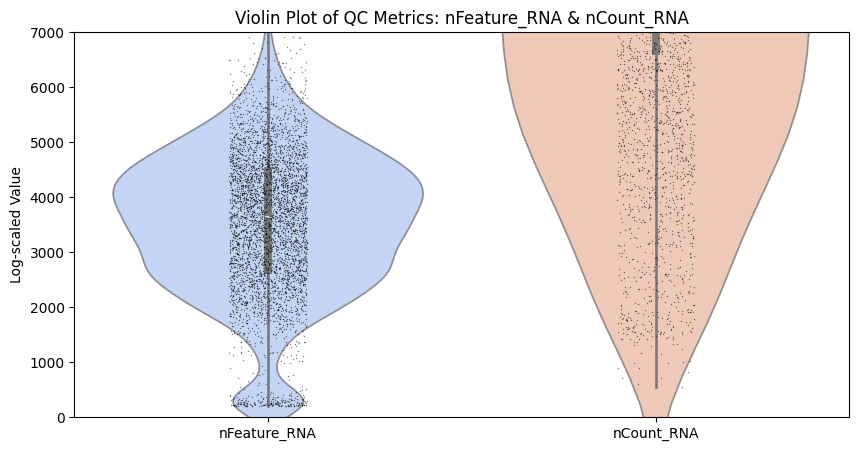

In [27]:
# Prepare data for plotting
qc_metrics = adata.obs[["nFeature_RNA", "nCount_RNA"]]
qc_metrics = qc_metrics.melt(var_name="QC Metric", value_name="Value")

# Create figure
plt.figure(figsize=(10, 5))

# Violin plot
sns.violinplot(x="QC Metric", y="Value", data=qc_metrics, palette="coolwarm", inner="box", alpha=0.8)

# Strip plot (dots for individual cells)
sns.stripplot(x="QC Metric", y="Value", data=qc_metrics, color="black", size=1, alpha=0.5, jitter=True)

# Labels and title
plt.yscale("linear")
plt.ylim(0, 7000)   # Log scale for better visualization
plt.xlabel("")
plt.ylabel("Log-scaled Value")
plt.title("Violin Plot of QC Metrics: nFeature_RNA & nCount_RNA")

plt.show()

Note:
- `nFeatureRNA` =  number of unique genes (or features) detected in each cell. Cells with very low nFeature_RNA may indicate poor-quality cells (e.g., empty droplets or dead cells), while cells with very high nFeature_RNA might indicate doublets or multiplets.
- `nCount_RNA` = sum of counts (or RNA transcripts) for all genes per cell. Interpretation is the same as features/cell.
- `seurat_clusters` = cell type cluster distribution.

In [28]:
# Define QC thresholds
min_genes = 200
max_genes = 5500
min_umis = 500

# Apply filters
adata = adata[(adata.obs["nFeature_RNA"] >= min_genes) &
              (adata.obs["nFeature_RNA"] <= max_genes) &
              (adata.obs["nCount_RNA"] >= min_umis)].copy()

# Check filtered dataset shape
print(f"Filtered dataset shape: {adata.shape}")

Filtered dataset shape: (4306, 21019)


Now that QC is done (which was hardly needed), let's proceed with:

- Identifying highly variable genes
- Scaling the data for PCA/clustering
- Dimensionality reduction (PCA, UMAP, t-SNE)
- Clustering to identify cell types

Since ML models work better with informative features, we’ll start by selecting highly variable genes.

In [29]:
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

Let's visualize them.

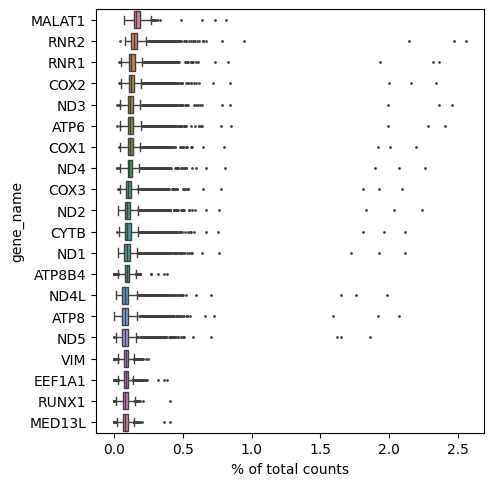

In [30]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [31]:
# Normalize total counts and log transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

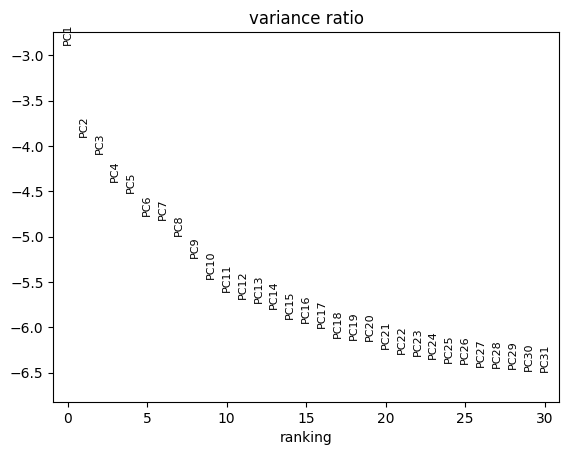

In [32]:
# Scale the data
sc.pp.scale(adata, max_value=10)

# Perform PCA (dimensionality reduction)
sc.tl.pca(adata, svd_solver='arpack')

# Visualize PCs
sc.pl.pca_variance_ratio(adata, log=True)

In [33]:
# Save the principal components as a new adata attribute
adata.obsm['X_pca'] = adata.obsm['X_pca'][:, :30]  # Keep the top 30 components

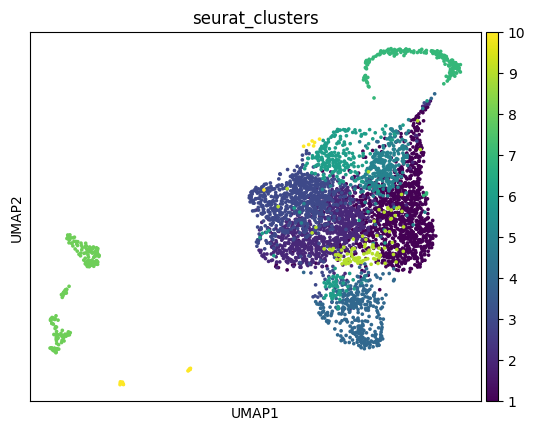

In [34]:
# Compute neighborhood graph
sc.pp.neighbors(adata, n_pcs=30)

# Cluster the cells
sc.tl.umap(adata, n_components=2)

# Visualize clusters
sc.pl.umap(adata, color='seurat_clusters')

Now that we've processed our data, let's get on to the machine learning!

We'll need to create labels for our supervised learning model. For this, prior biological knowledge is necessary. So in our case, we'll use a publicly accessible dataset from [Open Targets](https://platform.opentargets.org/downloads/data) containing generic druggable targets and their associated metadata, to classify our genes of interest as being associated with druggable targets or not.

In [35]:
target_data = pd.read_csv(
    "/content/drive/MyDrive/genspace/merged-data",
    quotechar='"',  # Specifies that double quotes enclose text
    skipinitialspace=True,  # Skip spaces after delimiters
    engine="python",  # Use Python engine to better handle irregularities
    on_bad_lines="skip"  # Skip problematic rows automatically
)

print(target_data.head())

                id approvedSymbol         biotype  \
0  ENSG00000000971            CFH  protein_coding   
1  ENSG00000007001           UPP2  protein_coding   
2  ENSG00000009694          TENM1  protein_coding   
3  ENSG00000011009         LYPLA2  protein_coding   
4  ENSG00000019582           CD74  protein_coding   

                                       transcriptIds  \
0  ['ENST00000359637' 'ENST00000695984' 'ENST0000...   
1  ['ENST00000605860' 'ENST00000460456' 'ENST0000...   
2  ['ENST00000422452' 'ENST00000371130' 'ENST0000...   
3  ['ENST00000374503' 'ENST00000374501' 'ENST0000...   
4  ['ENST00000518797' 'ENST00000523836' 'ENST0000...   

                                 canonicalTranscript  \
0  {'id': 'ENST00000367429', 'chromosome': '1', '...   
1  {'id': 'ENST00000005756', 'chromosome': '2', '...   
2  {'id': 'ENST00000422452', 'chromosome': 'X', '...   
3  {'id': 'ENST00000374514', 'chromosome': '1', '...   
4  {'id': 'ENST00000009530', 'chromosome': '5', '...   

       

In [36]:
adata.var

,Gene,highly_variable,means,dispersions,dispersions_norm,mean,std
gene_name,,,,,,,
WASH7P,ENSG00000227232,False,0.007865,0.049905,-0.610576,0.007904,0.090359
CICP27,ENSG00000233750,False,0.001856,-0.001627,-0.744722,0.001895,0.044014
WASH9P,ENSG00000279457,False,0.012233,0.162666,-0.317046,0.012039,0.114881
RPL23AP21,ENSG00000228463,False,0.007173,0.115196,-0.440617,0.006905,0.084324
MTND1P23,ENSG00000225972,False,0.100448,0.261618,-0.059463,0.101693,0.339386
...,...,...,...,...,...,...,...
ND6,ENSG00000198695,True,0.624544,1.111463,1.632811,0.560187,0.717827
TRNE,ENSG00000210194,True,0.602286,0.814973,0.985641,0.572278,0.700762
CYTB,ENSG00000198727,False,3.966138,3.829849,-0.707107,2.431598,0.319022


In [37]:
# Extract the column containing gene names from target_data
target_genes = target_data['approvedSymbol'].unique()

# Add a new column 'is_target' to adata.var
adata.var['is_target'] = adata.var.index.isin(target_genes).astype(int)

# Verify the integration and labels
print(adata.var.head())

                      Gene  highly_variable     means  dispersions  \
gene_name                                                            
WASH7P     ENSG00000227232            False  0.007865     0.049905   
CICP27     ENSG00000233750            False  0.001856    -0.001627   
WASH9P     ENSG00000279457            False  0.012233     0.162666   
RPL23AP21  ENSG00000228463            False  0.007173     0.115196   
MTND1P23   ENSG00000225972            False  0.100448     0.261618   

           dispersions_norm      mean       std  is_target  
gene_name                                                   
WASH7P            -0.610576  0.007904  0.090359          0  
CICP27            -0.744722  0.001895  0.044014          0  
WASH9P            -0.317046  0.012039  0.114881          0  
RPL23AP21         -0.440617  0.006905  0.084324          0  
MTND1P23          -0.059463  0.101693  0.339386          1  


In [38]:
na_columns = adata.var.isna().any()
print(na_columns)

Gene                False
highly_variable     False
means               False
dispersions         False
dispersions_norm    False
mean                False
std                 False
is_target           False
dtype: bool


Now that we've used the drug-target information to label druggable targets in our data appropriately, let's prepare our features and labels for machine learning.

Note: The dimensions of `adata.X` need to align with those of `adata.var['is_target'].`

- adata.X is a matrix with dimensions (n_cells, n_genes), where n_cells is the number of cells and n_genes is the number of genes/features.
- adata.var['is_target'] is a vector with length n_genes, representing annotations for genes.

In [39]:
# Features: Highly variable disease-specific genes (to minimize noise)
X = adata.X.T

# Labels: Gene targets
y = adata.var['is_target'].values


In [40]:
print(f"Features (X): {X.shape}")
print(f"Labels (y): {y.shape}")


Features (X): (21019, 4306)
Labels (y): (21019,)


Now to build a Random Forest classifier. This is an ensemble algorithm that combines multiple Decision Trees to make predictions. Essentially, this creates a "forest" of trees, where each tree is trained on a random subset of data and features. This results in a more robust and accurate prediction, by taking the collective decision from all the trees.

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve, average_precision_score
)


# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Train model

Note: Training the model can sometimes take a few mins.

In [42]:
# Initialize Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")  # Balances classes

# Train the model
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)
y_probs = rf_clf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

### Evaluate performance

- Accuracy: Basic evaluation metric that measures how many predictions the model got correct out of all predictions made

- Precision (Positive Predictive Value):
The percentage of predicted positives that are actually correct

- Recall (Sensitivity or True Positive Rate):
The percentage of actual positives that were correctly predicted


Question 1: Why is accuracy not a great metric to use for imbalanced classes?

Question 2: In what case might someone prioritize recall performance over precision?

In [43]:
# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8114
Precision: 0.1296
Recall: 0.0093


### Plot ROC-AUC curve

The ROC curve is a plot of:

- True Positive Rate (Recall or Sensitivity) on the Y-axis i.e how many actual positives were correctly identified
- False Positive Rate (1 - Specificity) on the X-axis i.e how many actual negatives were incorrectly classified as positives

The AUC (Area Under the Curve) quantifies the overall performance of the model.

AUC = 1.0 → Perfect model (ideal separation of classes).
AUC = 0.5 → Random guessing (no discrimination power).
AUC < 0.5 → Worse than random (model is making incorrect predictions)



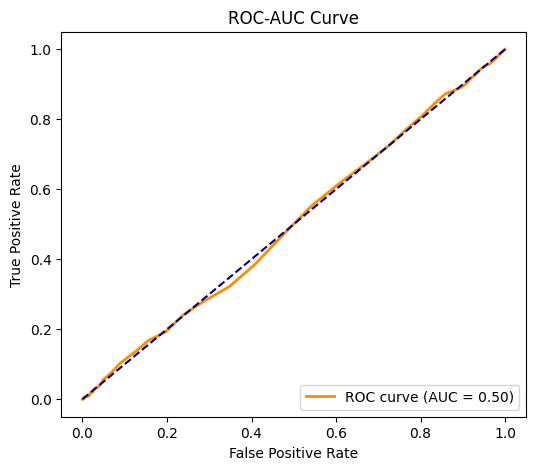

In [44]:
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # Random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend(loc="lower right")
plt.show()

### Plot P-R curve

A Precision-Recall (PR) curve is a performance evaluation metric used especially for imbalanced datasets in binary classification problems. It helps measure how well a model distinguishes between positive (1) and negative (0) classes by analyzing precision and recall at different classification thresholds. This is a better evaluation metric for our use case.



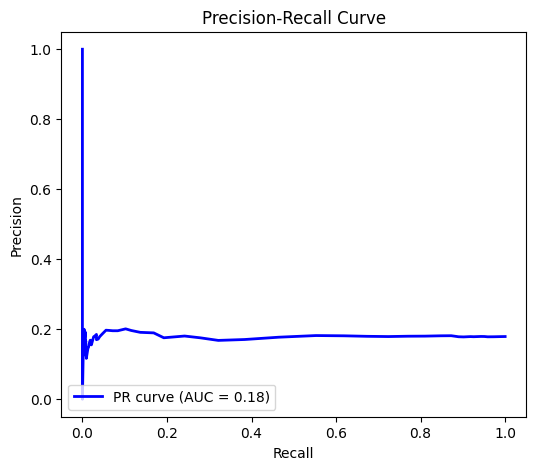

PR-AUC Score: 0.1800


In [45]:
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(recall_vals, precision_vals, color="blue", lw=2, label=f"PR curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()
print(f"PR-AUC Score: {pr_auc:.4f}")

Our model performance isn't great, so let's try improving its predictive capability with synthetic oversampling of the minority class (SMOTE).

Importantly, what NOT to do:

- Apply SMOTE to the entire dataset before splitting. This causes data leakage since the test set will contain synthetic samples that were derived from the training set.

- Apply SMOTE to the test set. The test set should always reflect real-world data.

In [47]:
# Split before applying SMOTE to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [49]:
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Apply SMOTE only on the training set
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train the model again
clf = RandomForestClassifier(class_weight="balanced", random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Test the model on the original test set (untouched)
y_pred = clf.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.96      0.88      3451
           1       0.18      0.04      0.07       753

    accuracy                           0.79      4204
   macro avg       0.50      0.50      0.48      4204
weighted avg       0.71      0.79      0.74      4204



ROC-AUC: 0.50


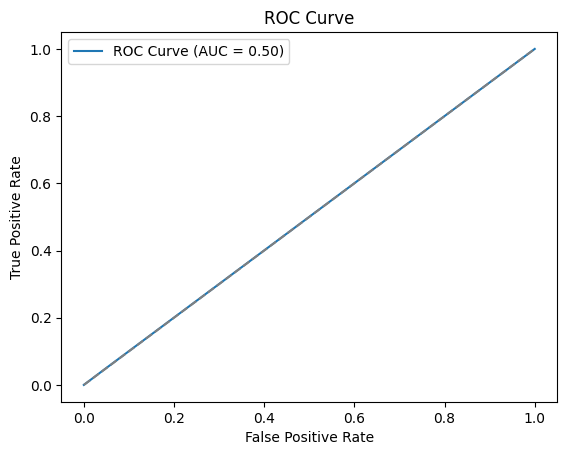

In [50]:
from sklearn.metrics import roc_auc_score, roc_curve

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.2f}")

# Plot the ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

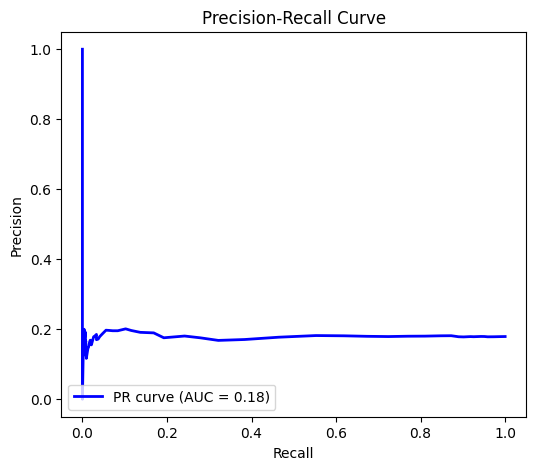

PR-AUC Score: 0.1800


In [51]:
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(recall_vals, precision_vals, color="blue", lw=2, label=f"PR curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()
print(f"PR-AUC Score: {pr_auc:.4f}")

In [53]:
import numpy as np

# Get indices of genes predicted as targets
predicted_targets_indices = np.where(y_pred == 1)[0]

# Map indices to gene names
predicted_targets = adata.var.index[predicted_targets_indices]

print(f"Predicted Drug Targets: {predicted_targets}")

Predicted Drug Targets: Index(['CFAP74', 'PLCH2', 'TP73-AS2', 'CA6', 'NMNAT1', 'FBLIM1', 'MT1XP1',
       'SDHB', 'OTUD3', 'CDA',
       ...
       'ALAS1', 'DNAH1', 'PBRM1', 'APPL1', 'ABHD6', 'WDR53P1', 'FOXP1',
       'ENPP7P2', 'ADGRG7', 'CEP97'],
      dtype='object', name='gene_name', length=177)


In [54]:
# Extract feature importances
importances = clf.feature_importances_

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Print top 10 important features
print("Top 10 Important Features:")
for i in range(10):
    print(f"Feature {indices[i]}: Importance {importances[indices[i]]:.4f}")

Top 10 Important Features:
Feature 3182: Importance 0.0100
Feature 2502: Importance 0.0086
Feature 2376: Importance 0.0059
Feature 2138: Importance 0.0052
Feature 706: Importance 0.0048
Feature 2168: Importance 0.0047
Feature 4273: Importance 0.0046
Feature 2895: Importance 0.0046
Feature 2599: Importance 0.0040
Feature 3587: Importance 0.0038


To conclude, in this case, ML might seem unnecessary because we already have the ground truth (the known drug targets) and could base our conclusions on that alone.

But ML adds value when you want to go beyond your labeled data; for example, to discover novel targets not included in the list of known targets.

Also, instead of manually inspecting thousands of genes, ML can systematically rank or classify genes based on their likelihood of being drug targets. This is useful for massive datasets will millions and billions of features.

Use cases for ML in this project include:

1. Rank Novel Drug Targets:
Predict which unlabeled genes have a high likelihood of being drug targets.
Sort and rank genes for prioritization based on their model-predicted probabilities.

2. Feature Importance Analysis:
Use ML models (e.g., Random Forest) to identify which features (e.g., expression variability, disease specificity) are most important for predicting drug targets.

3. Handle Data Noise:
scRNA-seq data is noisy, and manual methods might miss subtle patterns. ML can help filter noise and identify robust patterns.

4. Integrate Multi-Omics Data:
If you have additional data types (e.g., protein-protein interactions or genetic variants), ML models can integrate them with expression data to improve predictions